# Converting Cheyenne netCDF files to REFD files

In [1]:
import xarray as xr

loc = "D:/D4/"
convert_loc = "D:/D4_REFD_COM/"
obs_loc = "D:/D4_REFD_COM_OBS/"

### Read in the available files from `loc` and extract the REFD_COM
### Set the time dimension in the new dataset so dask can be used
### Transfer the global and variable attributes
### Save the new file in `convert_loc`

Note that not all the files are downloaded yet

In [2]:
import glob
import datetime
import numpy as np

for fname in glob.glob(loc + "*AFWA_d01_2008-06*"):
    
    ds = xr.open_dataset(fname)
    
    dtime = datetime.datetime.strptime(ds.Times.values[0].decode('utf8'), '%Y-%m-%d_%H:%M:%S')
    
    dset = xr.Dataset({'REFD_COM': (('time', 'south_north', 'west_east'), ds.REFD_COM)},
                coords={'time': (('time'), np.array([dtime]))})
    dset.attrs = ds.attrs
    
    dset.REFD_COM.attrs['FieldType'] = ds.REFD_COM.attrs['FieldType']
    dset.REFD_COM.attrs['MemoryOrder'] = ds.REFD_COM.attrs['MemoryOrder']
    dset.REFD_COM.attrs['description'] = ds.REFD_COM.attrs['description']
    dset.REFD_COM.attrs['stagger'] = ds.REFD_COM.attrs['stagger']
    dset.REFD_COM.attrs['coordinates'] = ds.REFD_COM.attrs['coordinates']

    dset.to_netcdf(convert_loc + fname.split("\\")[-1])

### Read in all the new files using dask

In [4]:
ds = xr.open_mfdataset(convert_loc + "*")

ds

<xarray.Dataset>
Dimensions:   (south_north: 899, time: 2841, west_east: 1399)
Coordinates:
  * time      (time) datetime64[ns] 2008-06-01 ... 2008-06-30T14:00:00
Dimensions without coordinates: south_north, west_east
Data variables:
    REFD_COM  (time, south_north, west_east) float32 dask.array<shape=(2841, 899, 1399), chunksize=(1, 899, 1399)>
Attributes:
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      2008-06-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    DY:                              3750.0
    AERCU_OPT:                       0
    AERCU_FCT:                       1.0
    IDEAL_CASE:                      0
    DIFF_6TH_SLOPEOPT:               0
    AUTO_LEVELS_OPT:                 2
    DIFF_6TH_THRESH:                 0.1
    DZBOT:                           50.0
    DZSTRETCH_S:        

### The attributes for REFD_COM are also transferred

In [4]:
ds.REFD_COM

<xarray.DataArray 'REFD_COM' (time: 2841, south_north: 899, west_east: 1399)>
dask.array<shape=(2841, 899, 1399), dtype=float32, chunksize=(1, 899, 1399)>
Coordinates:
  * time     (time) datetime64[ns] 2008-06-01 ... 2008-06-30T14:00:00
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  DERIVED COMPOSITE RADAR REFL
    stagger:      
    coordinates:  XLONG XLAT XTIME

### Set up the geography functions

In [2]:
from map_helper import *
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

from_proj = ccrs.PlateCarree()
projection = cartopy.crs.AlbersEqualArea(central_longitude=-96, central_latitude=37.5, false_easting=0.0, 
                            false_northing=0.0, standard_parallels=(29.5, 45.5), globe=None)

geog_fn = loc + "geo_em.d01.nc"

geog = xr.open_dataset(geog_fn)

lons, lats = geog.CLONG.values[0,:,:], geog.CLAT.values[0,:,:]

geog.close()

### Calculate the number of periods that experienced "convection", i.e., at least 40 dBZ

In [5]:
dsum = ds >= 40

dsum = dsum.sum('time')

#force dask to calculate
result = dsum.REFD_COM.values

### Plot the result

Text(0.5, 1.0, 'Count of Hours >= 40 dBZ\n 2008-06-01 00:00 UTC - 2008-06-30 14:00 UTC')

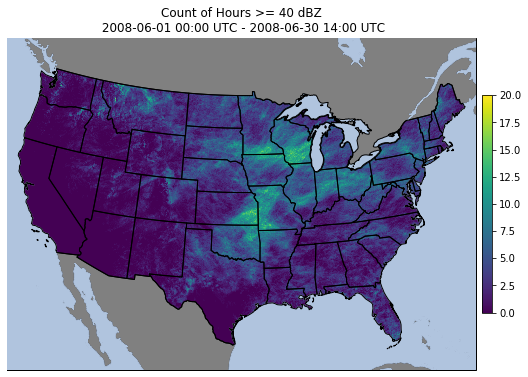

In [10]:
import pandas as pd

plt.rcParams['figure.figsize'] = 10, 10

ax = plt.subplot(1,1,1,projection=projection)
ax.set_extent([-120, -73, 23.5, 52.5], crs=from_proj)
ax = draw_geography(ax)

mmp = ax.pcolormesh(lons, lats, result/4, zorder=6, vmax=20, transform=ccrs.PlateCarree())

plt.colorbar(mmp, ax=ax, shrink=0.4, pad=0.01)

start_time = pd.to_datetime(str(ds.time.values[0])).strftime("%Y-%m-%d %H:%M")
end_time = pd.to_datetime(str(ds.time.values[-1])).strftime("%Y-%m-%d %H:%M")

plt.title("Count of Hours >= 40 dBZ\n {} UTC - {} UTC".format(start_time, end_time))

In [8]:
dsum_l = ds < 40

dsum_l = dsum_l.sum('time')

#force dask to calculate
result_l = dsum_l.REFD_COM.values

Text(0.5, 1.0, 'Count of Hours < 40 dBZ\n 2008-06-01 00:00 UTC - 2008-06-30 14:00 UTC')

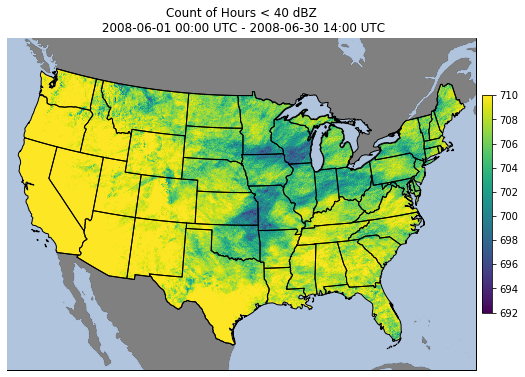

In [21]:
import pandas as pd

plt.rcParams['figure.figsize'] = 10, 10

ax = plt.subplot(1,1,1,projection=projection)
ax.set_extent([-120, -73, 23.5, 52.5], crs=from_proj)
ax = draw_geography(ax)

mmp = ax.pcolormesh(lons, lats, result_l/4, zorder=6, vmax=710, vmin=692, transform=ccrs.PlateCarree())

plt.colorbar(mmp, ax=ax, shrink=0.4, pad=0.01)

start_time = pd.to_datetime(str(ds.time.values[0])).strftime("%Y-%m-%d %H:%M")
end_time = pd.to_datetime(str(ds.time.values[-1])).strftime("%Y-%m-%d %H:%M")

plt.title("Count of Hours < 40 dBZ\n {} UTC - {} UTC".format(start_time, end_time))

### Oldschool way

In [9]:
import datetime

result1 = np.zeros(shape=(899, 1399), dtype=np.float32)

dtimes = []

for fname in glob.glob(loc + "*AFWA_d01_2008-06*"):
    
    ds = xr.open_dataset(fname)
    
    dtime = datetime.datetime.strptime(ds.Times.values[0].decode('utf8'), '%Y-%m-%d_%H:%M:%S')
    
    dtimes.append(dtime)

    refd = ds.REFD_COM.values.reshape(899, 1399)

    result1 += refd >= 40

### Map it

Text(0.5, 1.0, 'Number of Periods Matching Threshold Test (oldschool)\n 2008-06-01 00:00:00 - 2008-06-30 14:00:00')

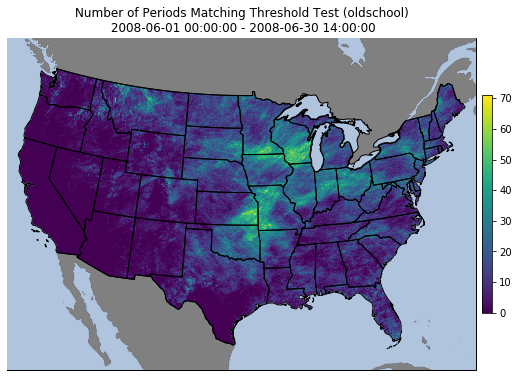

In [10]:
plt.rcParams['figure.figsize'] = 10, 10

ax = plt.subplot(1,1,1,projection=projection)
ax.set_extent([-120, -73, 23.5, 52.5], crs=from_proj)
ax = draw_geography(ax)

mmp = ax.pcolormesh(lons, lats, result1/4, zorder=6, transform=ccrs.PlateCarree())

plt.colorbar(mmp, ax=ax, shrink=0.4, pad=0.01)

start_time = dtimes[0]
end_time = dtimes[-1]

plt.title("Number of Periods Matching Threshold Test (oldschool)\n {} - {}".format(start_time, end_time))

### Differences

0.0


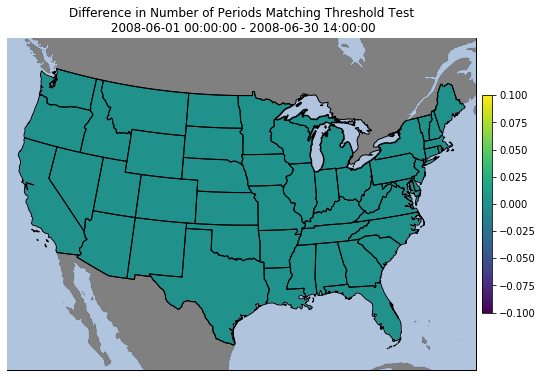

In [11]:
plt.rcParams['figure.figsize'] = 10, 10

ax = plt.subplot(1,1,1,projection=projection)
ax.set_extent([-120, -73, 23.5, 52.5], crs=from_proj)
ax = draw_geography(ax)

mmp = ax.pcolormesh(lons, lats, result-result1, zorder=6, transform=ccrs.PlateCarree())

plt.colorbar(mmp, ax=ax, shrink=0.4, pad=0.01)

start_time = dtimes[0]
end_time = dtimes[-1]

plt.title("Difference in Number of Periods Matching Threshold Test\n {} - {}".format(start_time, end_time))

print(np.sum(result-result1))

# OBS values from NOWrad

In [3]:
ds_now = xr.open_dataset(obs_loc + "NOWrad_2008-06-01.nc")

ds_now.REFD_COM

<xarray.DataArray 'REFD_COM' (time: 96, south_north: 899, west_east: 1399)>
[120739296 values with dtype=uint8]
Coordinates:
  * time     (time) datetime64[ns] 2008-06-01 ... 2008-06-01T23:45:00
Dimensions without coordinates: south_north, west_east
Attributes:
    description:  2km NOWrad nearest neighbor interpolated to 3.75 km D4 Grid...
    units:        dBZ divided by 5
    coordinates:  XLONG XLAT TIME

In [ ]:
ds_now = xr.open_mfdataset(obs_loc + "NOWrad*.nc")

dsum = ds_now.groupby(ds_now.time.date).sum()

In [16]:
ds_now = xr.open_mfdataset(obs_loc + "NOWrad*.nc")
ds_now = ds_now.sel(time=slice('2008-06-01', '2008-06-30 14:00:00'))

dsum = ds_now >= 8

dsum = dsum.sum('time')

#force dask to calculate
result_n = dsum.REFD_COM.values

Text(0.5, 1.0, 'Count of Hours >= 40 dBZ\n 2008-06-01 00:00 UTC - 2008-06-30 14:00 UTC')

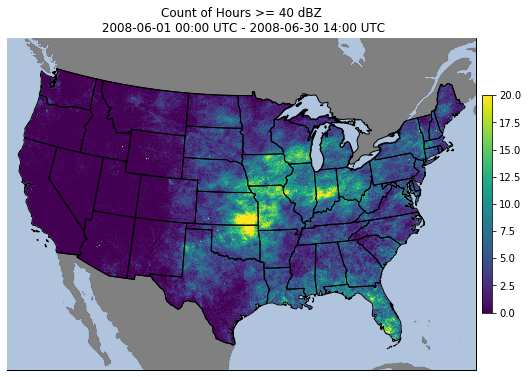

In [17]:
plt.rcParams['figure.figsize'] = 10, 10

ax = plt.subplot(1,1,1,projection=projection)
ax.set_extent([-120, -73, 23.5, 52.5], crs=from_proj)
ax = draw_geography(ax)

mmp = ax.pcolormesh(lons, lats, result_n/4, vmax=20, zorder=6, transform=ccrs.PlateCarree())

plt.colorbar(mmp, ax=ax, shrink=0.4, pad=0.01)

# start_time = dtimes[0]
# end_time = dtimes[-1]

plt.title("Count of Hours >= 40 dBZ\n {} UTC - {} UTC".format(start_time, end_time))

In [23]:
ds_now = xr.open_mfdataset(obs_loc + "NOWrad*.nc")
ds_now = ds_now.sel(time=slice('2008-06-01', '2008-06-30 14:00:00'))

dsum = ds_now < 8

dsum = dsum.sum('time')

#force dask to calculate
result_nl = dsum.REFD_COM.values

Text(0.5, 1.0, 'Count of Hours < 40 dBZ\n 2008-06-01 00:00 UTC - 2008-06-30 14:00 UTC')

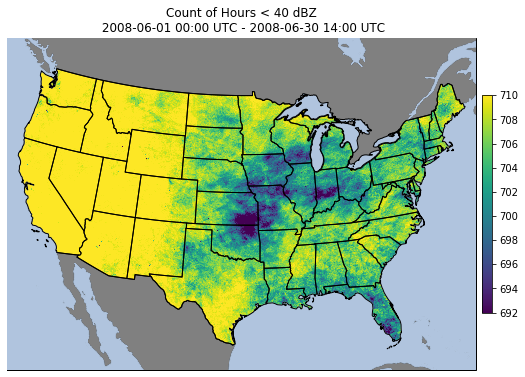

In [24]:
plt.rcParams['figure.figsize'] = 10, 10

ax = plt.subplot(1,1,1,projection=projection)
ax.set_extent([-120, -73, 23.5, 52.5], crs=from_proj)
ax = draw_geography(ax)

mmp = ax.pcolormesh(lons, lats, result_nl/4, vmax=710, vmin=692, zorder=6, transform=ccrs.PlateCarree())

plt.colorbar(mmp, ax=ax, shrink=0.4, pad=0.01)

# start_time = dtimes[0]
# end_time = dtimes[-1]

plt.title("Count of Hours < 40 dBZ\n {} UTC - {} UTC".format(start_time, end_time))

C:\Users\ahaberlie1\AppData\Local\Continuum\anaconda3\envs\r37\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
C:\Users\ahaberlie1\AppData\Local\Continuum\anaconda3\envs\r37\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


Text(0.5, 1.0, '% Diff in WRF/OBS Number of Hours >= 40 dBZ \n 2008-06-01 00:00 - 2008-06-30 14:00')

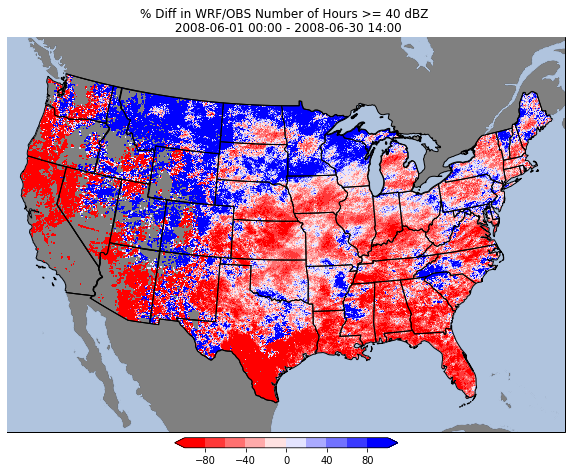

In [35]:
plt.rcParams['figure.figsize'] = 10, 10

ax = plt.subplot(1,1,1,projection=projection)
ax.set_extent([-120, -73, 23.5, 52.5], crs=from_proj)
ax = draw_geography(ax)

from matplotlib.colors import BoundaryNorm

cmap = plt.cm.bwr_r
classes = list(range(-100, 120, 20))
norm = BoundaryNorm(classes, ncolors=cmap.N, clip=True)

mmp = ax.pcolormesh(lons, lats, 100*((result/result_n)-1), cmap=cmap, norm=norm, zorder=6, transform=ccrs.PlateCarree())

plt.colorbar(mmp, ax=ax, shrink=0.4, pad=0.01, orientation='horizontal', extend='both')

# start_time = dtimes[0]
# end_time = dtimes[-1]

plt.title("% Diff in WRF/OBS Number of Hours >= 40 dBZ \n {} - {}".format(start_time, end_time))

In [37]:
np.nanmax((result/result_n)-1)

C:\Users\ahaberlie1\AppData\Local\Continuum\anaconda3\envs\r37\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
C:\Users\ahaberlie1\AppData\Local\Continuum\anaconda3\envs\r37\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


inf

In [ ]:
plt.rcParams['figure.figsize'] = 10, 10

ax = plt.subplot(1,1,1,projection=projection)
ax.set_extent([-120, -73, 23.5, 52.5], crs=from_proj)
ax = draw_geography(ax)

from matplotlib.colors import BoundaryNorm

cmap = plt.cm.bwr_r
classes = list(range(-4, 5, 1))
norm = BoundaryNorm(classes, ncolors=cmap.N, clip=True)

mmp = ax.pcolormesh(lons, lats, 100*((result_l/result_nl)-1), cmap=cmap, norm=norm, zorder=6, transform=ccrs.PlateCarree())

plt.colorbar(mmp, ax=ax, shrink=0.4, pad=0.01, orientation='horizontal', extend='both')

# start_time = dtimes[0]
# end_time = dtimes[-1]

plt.title("% Diff in WRF/OBS Number of Hours < 40 dBZ \n {} - {}".format(start_time, end_time))

### Oldschool way

In [16]:
import datetime
import glob

result1 = np.zeros(shape=(899, 1399), dtype=np.float32)

dtimes = []

for fname in glob.glob(obs_loc + "NOWrad*.nc"):
    
    ds = xr.open_dataset(fname)
    
    for ix in range(96):
        
        dtime = ds.time.values[ix]
        dtime = str(dtime)[:-10]
        dtimes.append(dtime)
        
        refd = ds.REFD_COM.values[ix]
        
        result1 += refd >= 8 #40 / 5 = 8

Text(0.5, 1.0, 'Number of OBS Periods Matching Threshold Test (oldschool)\n 2008-06-01T00:00:00 - 2008-06-30T23:45:00')

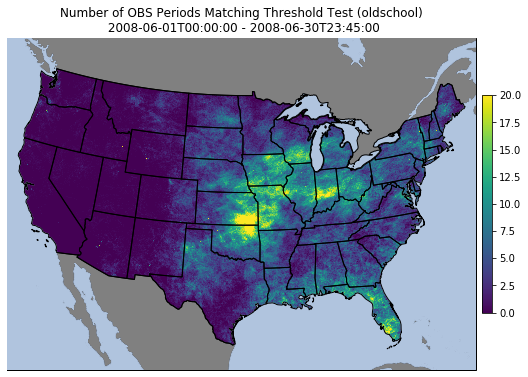

In [17]:
plt.rcParams['figure.figsize'] = 10, 10

ax = plt.subplot(1,1,1,projection=projection)
ax.set_extent([-120, -73, 23.5, 52.5], crs=from_proj)
ax = draw_geography(ax)

mmp = ax.pcolormesh(lons, lats, result1/4, vmax=20, zorder=6, transform=ccrs.PlateCarree())

plt.colorbar(mmp, ax=ax, shrink=0.4, pad=0.01)

start_time = dtimes[0]
end_time = dtimes[-1]

plt.title("Number of OBS Periods Matching Threshold Test (oldschool)\n {} - {}".format(start_time, end_time))

### Differences

0.0


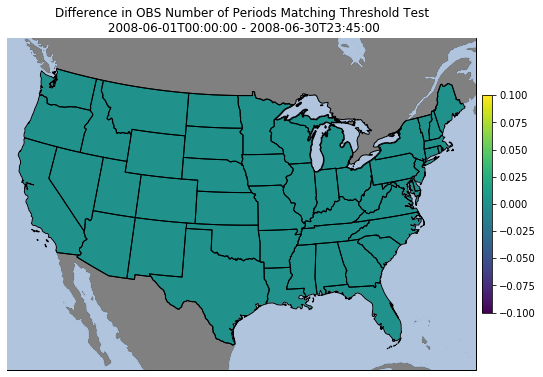

In [22]:
plt.rcParams['figure.figsize'] = 10, 10

ax = plt.subplot(1,1,1,projection=projection)
ax.set_extent([-120, -73, 23.5, 52.5], crs=from_proj)
ax = draw_geography(ax)



mmp = ax.pcolormesh(lons, lats, result-result1, zorder=6, transform=ccrs.PlateCarree())

plt.colorbar(mmp, ax=ax, shrink=0.4, pad=0.01)

start_time = dtimes[0]
end_time = dtimes[-1]

plt.title("Difference in OBS Number of Periods Matching Threshold Test\n {} - {}".format(start_time, end_time))

print(np.sum(result-result1))

# Differences between WRF and OBS

In [68]:
ds_now = xr.open_mfdataset(obs_loc + "NOWrad*.nc") 
ds_now *= 5

dsum = ds_now >= 50
dsum = dsum.sum('time')
#force dask to calculate
result_obs = dsum.REFD_COM.values
ds_now.close()

ds = xr.open_mfdataset(convert_loc + "*")
dsum = ds >= 50
dsum = dsum.sum('time')
#force dask to calculate
result_wrf = dsum.REFD_COM.values
ds.close()

In [75]:
ds = xr.open_dataset(convert_loc + "AFWA_d01_2008-06-30_14_00_00")

ds

<xarray.Dataset>
Dimensions:   (south_north: 899, time: 1, west_east: 1399)
Coordinates:
  * time      (time) datetime64[ns] 2008-06-30T14:00:00
Dimensions without coordinates: south_north, west_east
Data variables:
    REFD_COM  (time, south_north, west_east) float32 ...
Attributes:
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      2008-06-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    DY:                              3750.0
    AERCU_OPT:                       0
    AERCU_FCT:                       1.0
    IDEAL_CASE:                      0
    DIFF_6TH_SLOPEOPT:               0
    AUTO_LEVELS_OPT:                 2
    DIFF_6TH_THRESH:                 0.1
    DZBOT:                           50.0
    DZSTRETCH_S:                     1.3
    DZSTRETCH_U:                     1.1
    GRIDTYPE:     

In [4]:
from matplotlib.colors import BoundaryNorm

cmap = plt.cm.bwr_r
classes = list(range(-30, 30, 5))
norm = BoundaryNorm(classes, ncolors=cmap.N, clip=True)

Text(0.5, 1.0, 'Difference in WRF-OBS Number of Hours Matching Threshold (50 dBZ) Test\n 2008-06-01T00:00:00 - 2008-06-30T23:45:00')

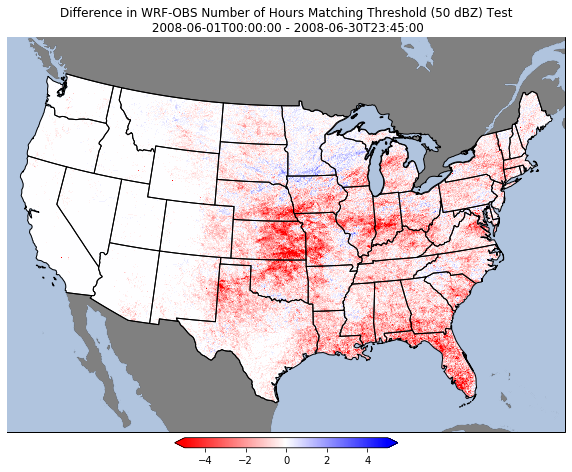

In [71]:
plt.rcParams['figure.figsize'] = 10, 10

ax = plt.subplot(1,1,1,projection=projection)
ax.set_extent([-120, -73, 23.5, 52.5], crs=from_proj)
ax = draw_geography(ax)

mmp = ax.pcolormesh(lons, lats, (result_wrf-result_obs) / 4, vmin=-5, vmax=5, cmap=cmap, zorder=6, transform=ccrs.PlateCarree())

plt.colorbar(mmp, ax=ax, shrink=0.4, pad=0.01, orientation='horizontal', extend='both')

start_time = dtimes[0]
end_time = dtimes[-1]

plt.title("Difference in WRF-OBS Number of Hours Matching Threshold (40 dBZ) Test\n {} - {}".format(start_time, end_time))

C:\Users\ahaberlie1\AppData\Local\Continuum\anaconda3\envs\r37\lib\site-packages\cartopy\mpl\geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
C:\Users\ahaberlie1\AppData\Local\Continuum\anaconda3\envs\r37\lib\site-packages\cartopy\mpl\geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
C:\Users\ahaberlie1\AppData\Local\Continuum\anaconda3\envs\r37\lib\site-packages\cartopy\mpl\geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
C:\Users\ahaberlie1\AppData\Local\Continuum\anaconda3\envs\r37\lib\site-packages\cartopy\mpl\geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


KeyboardInterrupt: 

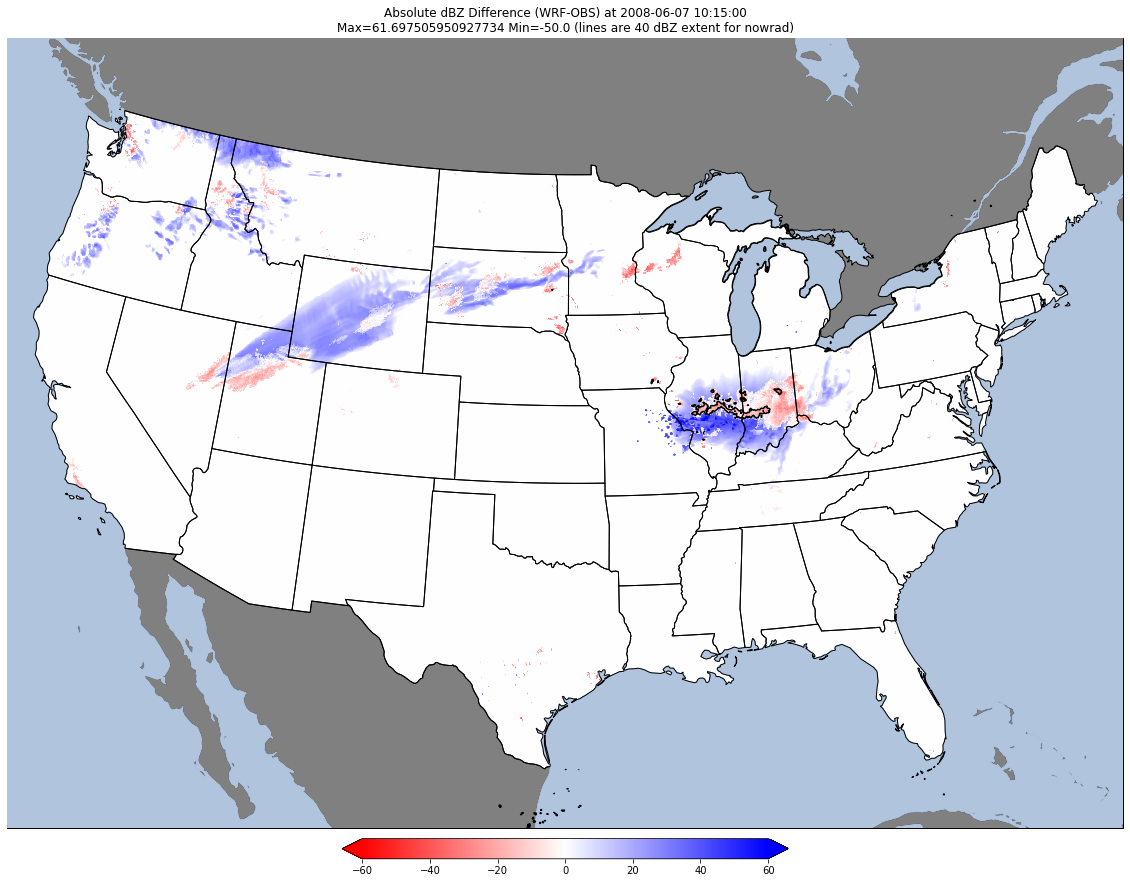

In [20]:
plt.rcParams['figure.figsize'] = 20, 20
import pandas as pd

# ds_now = xr.open_mfdataset(obs_loc + "NOWrad*.nc")
# ds_now *= 5

# ds = xr.open_mfdataset(convert_loc + "*")


rng = pd.date_range(start='2008-06-01', end='2008-06-30', freq='15T')

ix = 0

for date in rng:
    
    wrf = ds.sel(time=date)
    wrf = wrf.REFD_COM.values
    
    now = ds_now.sel(time=date)
    now = now.REFD_COM.values
    now[now>80] = 0
    
    ax = plt.subplot(1,1,1,projection=projection)
    ax.set_extent([-120, -73, 23.5, 52.5], crs=from_proj)
    ax = draw_geography(ax)

    mmp = ax.pcolormesh(lons, lats, wrf-now, vmin=-60, vmax=60, cmap=cmap, zorder=6, transform=ccrs.PlateCarree())
    
    ax.contour(lons, lats, now, levels=[40], transform=ccrs.PlateCarree(), 
               linestyles=['-'], colors=['k'], zorder=7)

    plt.colorbar(mmp, ax=ax, shrink=0.4, pad=0.01, orientation='horizontal', extend='both')
    
    plt.title("Absolute dBZ Difference (WRF-OBS) at {}\nMax={} Min={} (lines are 40 dBZ extent for nowrad)".format(date, np.max(wrf-now), np.min(wrf-now)))
    
    a = str(date).replace(" ", "")
    a = str(a).replace(":", "")

    a = str(ix).zfill(5) + "_" + a

    plt.savefig(a, bbox_inches='tight')

    plt.clf()
    
    ix += 1

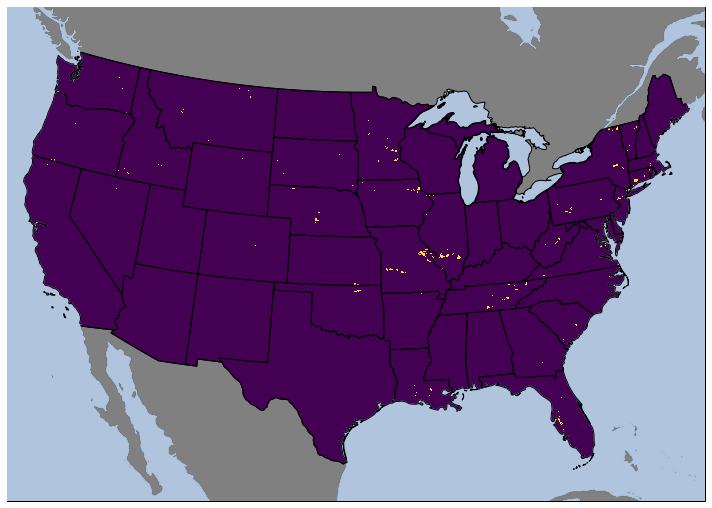

In [15]:
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

nws_reflectivity_colors = [ "#ffffff", # 0
                            "#04e9e7", # 5
                            "#019ff4", # 10
                            "#0300f4", # 15
                            "#02fd02", # 20
                            "#01c501", # 25
                            "#008e00", # 30
                            "#fdf802", # 35
                            "#e5bc00", # 40
                            "#fd9500", # 45
                            "#fd0000", # 50
                            "#d40000", # 55
                            "#bc0000", # 60
                            "#f800fd", # 65
                            "#9854c6", # 70
                            "#4B0082", # 75
                            "#000000"]
    
def radar_colormap():

    cmap = ListedColormap(nws_reflectivity_colors)

    return cmap

cmap1 = radar_colormap()
classes1 = list(range(0, 85, 5))
norm1 = BoundaryNorm(classes1, ncolors=cmap1.N, clip=True)

ax = plt.subplot(2,1,1,projection=projection)
ax.set_extent([-120, -73, 23.5, 52.5], crs=from_proj)
ax = draw_geography(ax)

mmp = ax.pcolormesh(lons, lats, now>40, zorder=6, transform=ccrs.PlateCarree())

In [90]:
a = str(date).replace(" ", "")
a = str(a).replace(":", "")

a = a[-6:] + "_" + a[:-6]
a

'000000_2008-06-02'

In [18]:
    a = str(date).replace(" ", "")
    a = str(a).replace(":", "")
    
    a

'2008-06-01004500'

In [19]:
    a = str(date).replace(" ", "")
    a = str(a).replace(":", "")

    a = a[-6:] + "_" + a[:-6] + ".png"
    
    a

'004500_2008-06-01.png'